In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_path = "dataset/UNSW_NB15_training-set.csv"
test_path = "dataset/UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(df_train.shape)
print(df_test.shape)

(82332, 45)
(175341, 45)


In [3]:
X_train = df_train.drop(columns=["label", "attack_cat"], errors="ignore")
y_train = df_train["label"]

X_test = df_test.drop(columns=["label", "attack_cat"], errors="ignore")
y_test = df_test["label"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(82332, 43) (82332,)
(175341, 43) (175341,)


In [5]:
import numpy as np
from pandas.api.types import is_numeric_dtype

X_train = X_train.replace("-", np.nan)
X_test = X_test.replace("-", np.nan)

for col in X_train.columns:
    if is_numeric_dtype(X_train[col]):
        X_train[col] = X_train[col].fillna(X_train[col].mean())
        X_test[col] = X_test[col].fillna(X_test[col].mean())
    else:
        X_train[col] = X_train[col].fillna(X_train[col].mode()[0])
        X_test[col] = X_test[col].fillna(X_test[col].mode()[0])

print("Missing values handled")

Missing values handled


In [6]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
print(cat_cols)

for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    le.fit(combined)

    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

print("Encoding done")

Index(['proto', 'service', 'state'], dtype='str')
Encoding done


C:\Users\HP\AppData\Local\Temp\ipykernel_5852\4152707082.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X_train.select_dtypes(include=["object"]).columns


In [7]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Random Forest trained")

Random Forest trained


In [8]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3982411415470426

Confusion Matrix:
 [[ 52736   3264]
 [102249  17092]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.94      0.50     56000
           1       0.84      0.14      0.24    119341

    accuracy                           0.40    175341
   macro avg       0.59      0.54      0.37    175341
weighted avg       0.68      0.40      0.33    175341



In [9]:
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_balanced.fit(X_train, y_train)

y_pred_bal = rf_balanced.predict(X_test)

print("Balanced RF Accuracy:", accuracy_score(y_test, y_pred_bal))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))

print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))

Balanced RF Accuracy: 0.3989825539947873

Confusion Matrix:
 [[ 52944   3056]
 [102327  17014]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.95      0.50     56000
           1       0.85      0.14      0.24    119341

    accuracy                           0.40    175341
   macro avg       0.59      0.54      0.37    175341
weighted avg       0.69      0.40      0.33    175341



ROC-AUC Score: 0.72684521993998


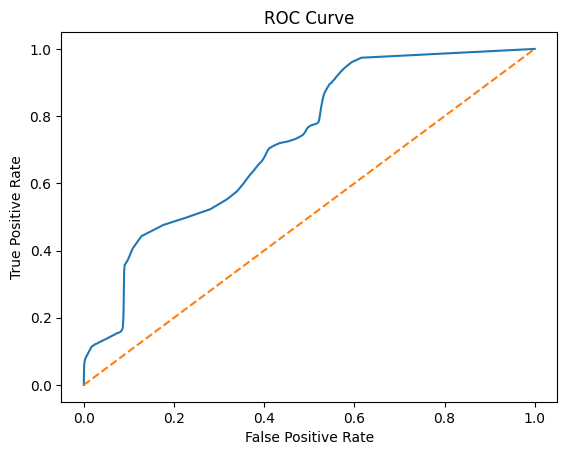

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_prob = rf_model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", auc_score)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

PR-AUC (Average Precision Score): 0.8319466847996835


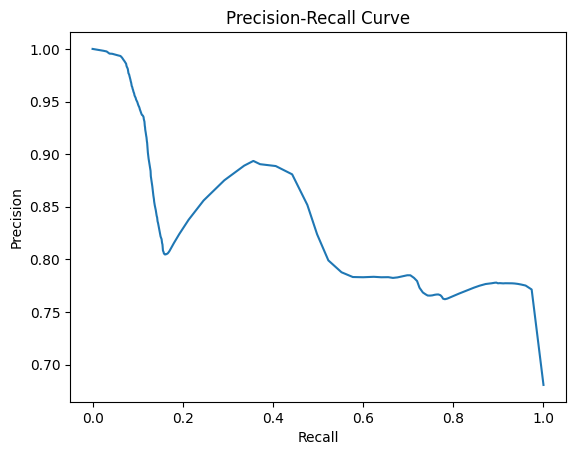

In [11]:
from sklearn.metrics import average_precision_score, precision_recall_curve

ap_score = average_precision_score(y_test, y_prob)
print("PR-AUC (Average Precision Score):", ap_score)

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_probs = rf_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)

    acc = accuracy_score(y_test, y_pred_t)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)

    print("Threshold:", round(t, 2), 
          "| Accuracy:", round(acc, 4), 
          "| Precision:", round(prec, 4), 
          "| Recall:", round(rec, 4), 
          "| F1:", round(f1, 4))

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nBest Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

Threshold: 0.1 | Accuracy: 0.744 | Precision: 0.7768 | Recall: 0.8754 | F1: 0.8231
Threshold: 0.15 | Accuracy: 0.6983 | Precision: 0.7656 | Recall: 0.8024 | F1: 0.7836
Threshold: 0.2 | Accuracy: 0.6754 | Precision: 0.7657 | Recall: 0.7535 | F1: 0.7596
Threshold: 0.25 | Accuracy: 0.6585 | Precision: 0.7839 | Recall: 0.6879 | F1: 0.7328
Threshold: 0.3 | Accuracy: 0.5858 | Precision: 0.8238 | Recall: 0.498 | F1: 0.6207
Threshold: 0.35 | Accuracy: 0.4224 | Precision: 0.8241 | Recall: 0.1924 | F1: 0.312
Threshold: 0.4 | Accuracy: 0.4017 | Precision: 0.8051 | Recall: 0.1595 | F1: 0.2663
Threshold: 0.45 | Accuracy: 0.4005 | Precision: 0.8191 | Recall: 0.153 | F1: 0.2579
Threshold: 0.5 | Accuracy: 0.3982 | Precision: 0.8397 | Recall: 0.1432 | F1: 0.2447
Threshold: 0.55 | Accuracy: 0.3966 | Precision: 0.8572 | Recall: 0.1361 | F1: 0.2348
Threshold: 0.6 | Accuracy: 0.3954 | Precision: 0.8775 | Recall: 0.1298 | F1: 0.2262
Threshold: 0.65 | Accuracy: 0.394 | Precision: 0.8975 | Recall: 0.1237 | F1

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

best_t = best_threshold
y_pred_best = (y_probs >= best_t).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Confusion Matrix:
 [[ 25972  30028]
 [ 14865 104476]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.46      0.54     56000
           1       0.78      0.88      0.82    119341

    accuracy                           0.74    175341
   macro avg       0.71      0.67      0.68    175341
weighted avg       0.73      0.74      0.73    175341



In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced", "balanced_subsample"]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=20,
    scoring="f1",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced'}
Best Score: 0.898418347958598


Accuracy: 0.40487393136802

Confusion Matrix:
 [[ 52611   3389]
 [100961  18380]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.94      0.50     56000
           1       0.84      0.15      0.26    119341

    accuracy                           0.40    175341
   macro avg       0.59      0.55      0.38    175341
weighted avg       0.68      0.40      0.34    175341

ROC-AUC Score: 0.8397183570309329


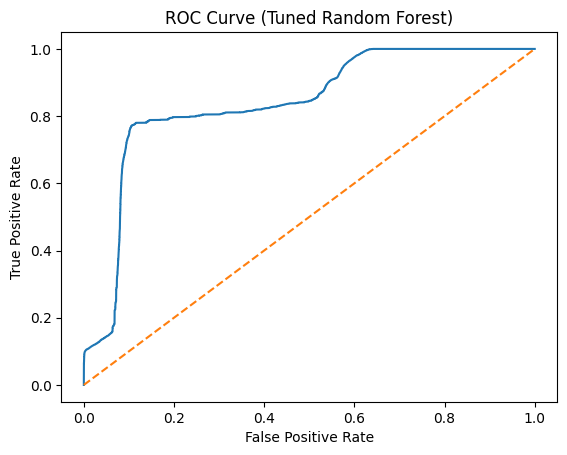

PR-AUC Score: 0.8976355381647022


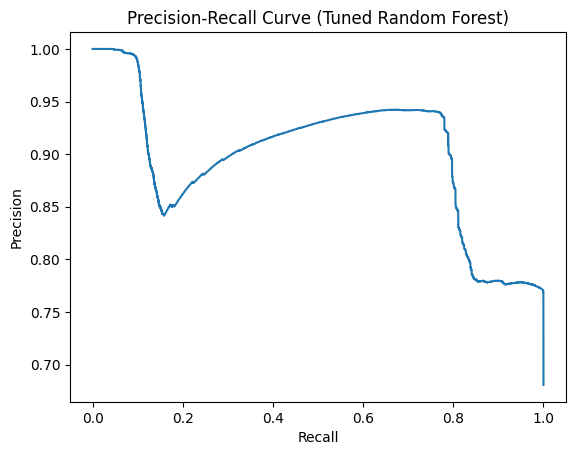

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

best_rf = random_search.best_estimator_

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned Random Forest)")
plt.show()

pr_auc = average_precision_score(y_test, y_prob)
print("PR-AUC Score:", pr_auc)

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tuned Random Forest)")
plt.show()

In [17]:
X_train = X_train.drop(columns=["id"], errors="ignore")
X_test = X_test.drop(columns=["id"], errors="ignore")

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score

y_probs = rf_model.predict_proba(X_test)[:, 1]

best_acc = 0
best_thresh = 0

for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

print("Best Threshold:", best_thresh)
print("Best Accuracy:", best_acc)

Best Threshold: 0.1
Best Accuracy: 0.9290012033694344


In [20]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

et_model = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

et_model.fit(X_train, y_train)

y_pred = et_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8989454833724001
[[ 54694   1306]
 [ 16413 102928]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     56000
           1       0.99      0.86      0.92    119341

    accuracy                           0.90    175341
   macro avg       0.88      0.92      0.89    175341
weighted avg       0.92      0.90      0.90    175341



ROC-AUC Score: 0.9814373381738044


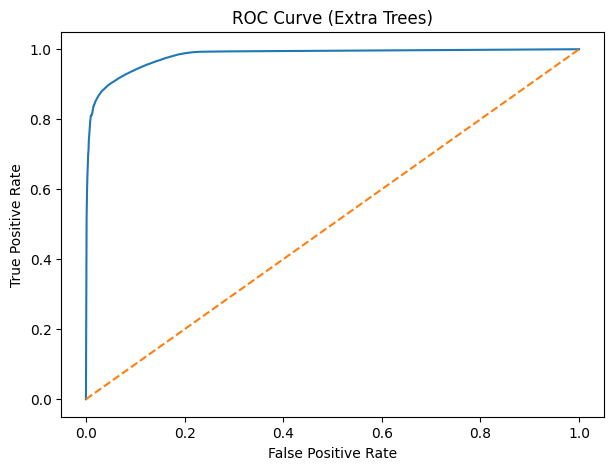

PR-AUC Score: 0.9905564879029471


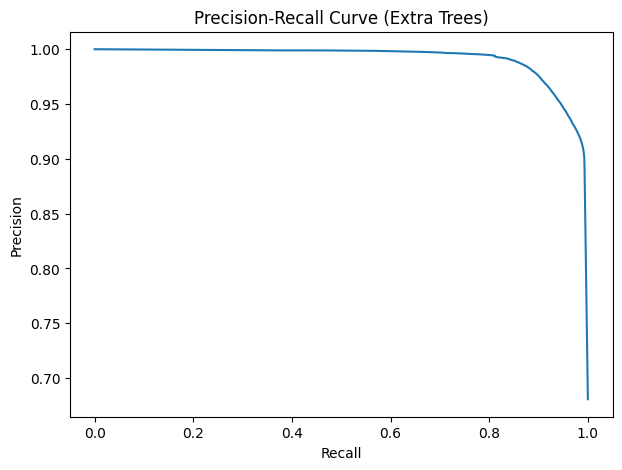

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

y_probs = et_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Extra Trees)")
plt.show()

pr_auc = average_precision_score(y_test, y_probs)
print("PR-AUC Score:", pr_auc)

precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Extra Trees)")
plt.show()

In [22]:
mkdir notebooks src results